# Setup 4x4 GridWorld Environment

In [ ]:
import numpy as np

class GridWorld: 
    def __init__(self, size=4): 
        self.size = size
        self.grid = np.zeros((size, size))
        self.start = (0, 0)
        self.goal = (size-1, size-1)
        self.actions = ['U', 'D', 'L', 'R']
        self.state = self.start

    def reset(self): 
        self.state = self.start
        return self.state
    
    def step(self, action): 
        x,y =  self.state
        if action == 'U': 
            x = max(x-1,0)
        elif action == 'D': 
            x = min(x+1, self.size-1)
        elif action == 'L': 
            y = max(y-1,0)
        elif action == 'R': 
            y = min(y+1, self.size-1)
        
        self.state = (x,y)
        reward = -1 # small penalty for each step
        if self.state == self.goal: 
            reward = 10
            done = True
        else: 
            done = False
        
        return self.state, reward, done
    
    def get_all_states(self): 
        return [(x,y) for x in range(self.size) for y in range(self.size)]

    def is_terminal(self, state): 
        return state == self.goal
        

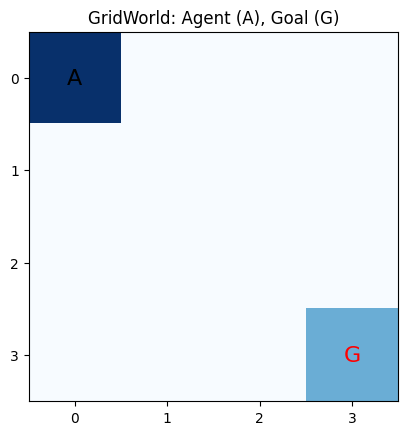

In [15]:
env = GridWorld(size=4)

# Visualize the environment grid and agent position
import matplotlib.pyplot as plt

def plot_env(env):
    grid = np.zeros((env.size, env.size))
    x, y = env.state
    gx, gy = env.goal
    grid[gx, gy] = 0.5  # Mark goal
    grid[x, y] = 1.0    # Mark agent
    plt.imshow(grid, cmap='Blues', vmin=0, vmax=1)
    plt.xticks(range(env.size))
    plt.yticks(range(env.size))
    # plt.gca().invert_yaxis()
    plt.text(gy, gx, 'G', ha='center', va='center', color='red', fontsize=16)
    plt.text(y, x, 'A', ha='center', va='center', color='black', fontsize=16)
    plt.title("GridWorld: Agent (A), Goal (G)")
    plt.show()

plot_env(env)

In [4]:
env

# Implement Value Iteration for GridWorld 

In [9]:
def value_iteration(env, gamma=0.9, theta=1e-6): 
    V = {state: 0 for state in env.get_all_states()}
    policy = {}

    while True: 
        delta = 0
        for state in env.get_all_states(): 
            if env.is_terminal(state): 
                continue
            v = V[state]
            action_values = []

            for action in env.actions:
                env.state = state # temporarily set state
                next_state, reward, _ = env.step(action)
                value = reward + gamma * V[next_state]
                action_values.append(value)
            V[state] = max(action_values)
            delta = max(delta, abs(v - V[state]))

        if delta < theta:
            break
    
    # Extract Policy
    for state in env.get_all_states():
        if env.is_terminal(state): 
            policy[state] = None
            continue

        action_values = []
        for action in env.actions:
            env.state = state
            next_state, reward, _ = env.step(action)
            value = reward + gamma * V[next_state]
            action_values.append(value)

        best_action = env.actions[np.argmax(action_values)]
        policy[state] = best_action

    return V, policy

In [11]:
V, policy = value_iteration(env)

In [18]:
print("Optimal Policy:")
for state in env.get_all_states():
    if state != env.goal:
        print(f"  {state}: {policy[state]}")

Optimal Policy:
  (0, 0): D
  (0, 1): D
  (0, 2): D
  (0, 3): D
  (1, 0): D
  (1, 1): D
  (1, 2): D
  (1, 3): D
  (2, 0): D
  (2, 1): D
  (2, 2): D
  (2, 3): D
  (3, 0): R
  (3, 1): R
  (3, 2): R


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_policy(env, policy, V):
    """
    Visualize the optimal policy as arrows on a grid and superimpose V values.

    Args:
        env (GridWorld): The GridWorld environment instance.
        policy (dict): Dictionary mapping states to optimal actions.
        V (dict): Dictionary mapping states to their optimal values.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Create a grid for visualization
    grid = np.zeros((env.size, env.size))
    
    # Mark goal
    gx, gy = env.goal
    grid[gx, gy] = 0.5
    
    # Display the grid (default origin='upper' means (0,0) is top-left)
    ax.imshow(grid, cmap='Blues', vmin=0, vmax=1)
    
    # Define arrow directions for each action
    arrows = {
        'U': (0, -0.3),   # Up arrow (visually moves towards top)
        'D': (0, 0.3),    # Down arrow (visually moves towards bottom)
        'L': (-0.3, 0),   # Left arrow (visually moves towards left)
        'R': (0.3, 0)     # Right arrow (visually moves towards right)
    }
    
    # Draw arrows and V values for each state
    for i in range(env.size):
        for j in range(env.size):
            state = (i, j)
            
            # Display V value
            if state != env.goal:
                value = V.get(state, 0.0) # Use .get to handle states not explicitly in V if any
                ax.text(j, i - 0.2, f'{value:.2f}', # Adjust vertical position for text
                        ha='center', va='center', fontsize=10, color='blue', weight='bold')
            
            # Draw policy arrows (only if not goal)
            if state != env.goal:
                action = policy.get(state, None) # Use .get for robustness
                if action in arrows:
                    dx, dy = arrows[action]
                    # Note: matplotlib ax.arrow uses (x_coord, y_coord, dx, dy)
                    # In our case, x_coord is column (j), y_coord is row (i)
                    ax.arrow(j, i + 0.1, dx, dy, head_width=0.1, head_length=0.1, 
                            fc='red', ec='red', linewidth=2)
            else:
                # Mark goal state
                ax.text(j, i, 'GOAL', ha='center', va='center', 
                       fontsize=12, fontweight='bold', color='green')
    
    # Add grid lines and labels
    ax.set_xticks(range(env.size))
    ax.set_yticks(range(env.size))
    ax.grid(True, alpha=0.3)
    
    ax.set_title('Optimal Policy and Value Function Visualization', 
                fontsize=14)
    ax.set_xlabel('Y coordinate')
    ax.set_ylabel('X coordinate')
    
    plt.tight_layout()
    plt.show()

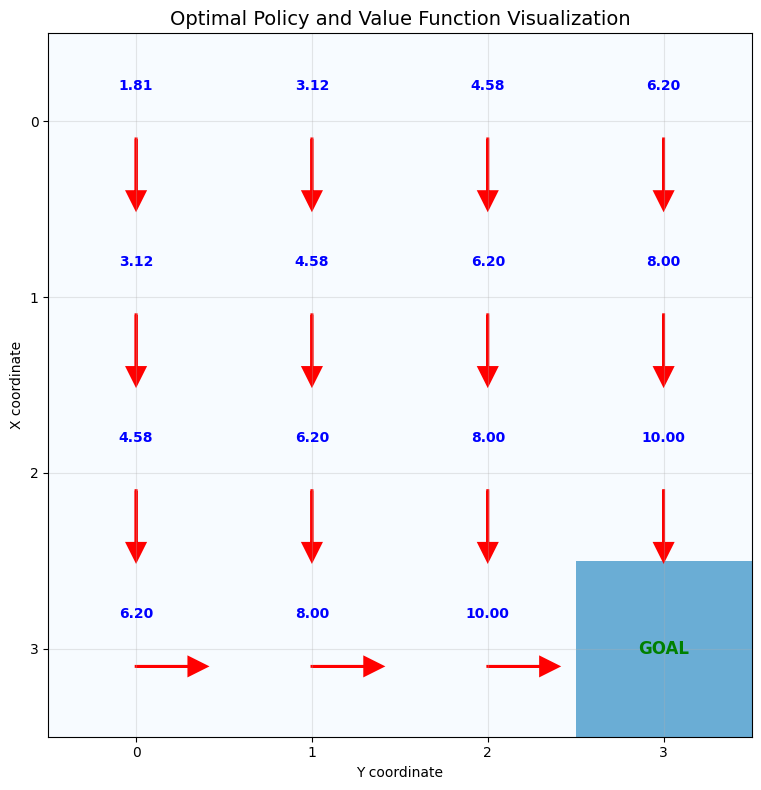

In [28]:
visualize_policy(env, policy, V)

In [29]:
V

{(0, 0): 1.8098,
 (0, 1): 3.122,
 (0, 2): 4.58,
 (0, 3): 6.2,
 (1, 0): 3.122,
 (1, 1): 4.58,
 (1, 2): 6.2,
 (1, 3): 8.0,
 (2, 0): 4.58,
 (2, 1): 6.2,
 (2, 2): 8.0,
 (2, 3): 10.0,
 (3, 0): 6.2,
 (3, 1): 8.0,
 (3, 2): 10.0,
 (3, 3): 0}

# Advancing the complexity of the GridWorld environment

## Adding obstacles

In [73]:
import numpy as np

class GridWorldObstacle: 
    def __init__(self, size=4, obstacle=[(2,3)]): 
        self.size = size
        self.grid = np.zeros((size, size))
        self.start = (0, 0)
        self.goal = (size-1, size-1)
        self.actions = ['U', 'D', 'L', 'R']
        self.state = self.start
        self.obstacle = obstacle

    def reset(self): 
        self.state = self.start
        return self.state
    
    def step(self, action): 
        x,y =  self.state
        if action == 'U': 
            x = max(x-1,0)
        elif action == 'D': 
            x = min(x+1, self.size-1)
        elif action == 'L': 
            y = max(y-1,0)
        elif action == 'R': 
            y = min(y+1, self.size-1)
        
        if (x,y) in self.obstacle:
            reward = -1000
            done = False # hitting an obstacle doesn't end the episode
        else:
            self.state = (x,y)
            reward = -1 # default step penalty
    
            if self.state == self.goal: 
                reward = 10
                done = True
            else: 
                done = False
        
        return self.state, reward, done
    
    def get_all_states(self): 
        # I don't want to return states that are obstacles
        all_states = [(x,y) for x in range(self.size) for y in range(self.size)]
        return list(set(all_states) - set(self.obstacle))

    def is_terminal(self, state): 
        return state == self.goal
        

In [74]:
env = GridWorldObstacle(size=4, obstacle=[(1,3)])

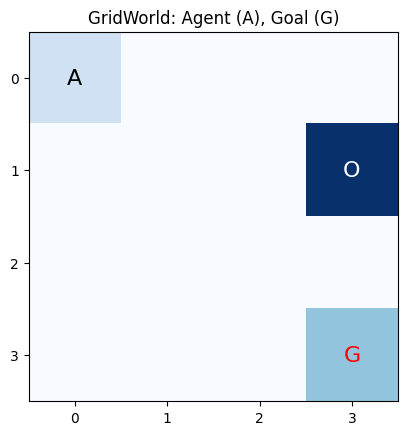

In [5]:
# Visualize the environment grid and agent position
import matplotlib.pyplot as plt

def plot_env(env):
    grid = np.zeros((env.size, env.size))
    x, y = env.state
    gx, gy = env.goal
    for ox, oy in env.obstacle: 
        grid[ox, oy] = 1.0 # Mark obstacle
        plt.text(oy, ox, 'O', ha='center', va='center', color='white', fontsize=16)
    grid[gx, gy] = 0.4  # Mark goal
    grid[x, y] = 0.2    # Mark agent
    grid[ox, oy] = 1.0  # Mark Obstacle
    plt.imshow(grid, cmap='Blues', vmin=0, vmax=1)
    plt.xticks(range(env.size))
    plt.yticks(range(env.size))
    # plt.gca().invert_yaxis()
    plt.text(gy, gx, 'G', ha='center', va='center', color='red', fontsize=16)
    plt.text(y, x, 'A', ha='center', va='center', color='black', fontsize=16)
    plt.title("GridWorld: Agent (A), Goal (G)")
    plt.show()

plot_env(env)

## Running the value iteration algorithm we created above to get policy for this new grid world with an obstacle

In [76]:
V, policy = value_iteration(env)

In [77]:
len(policy)

15

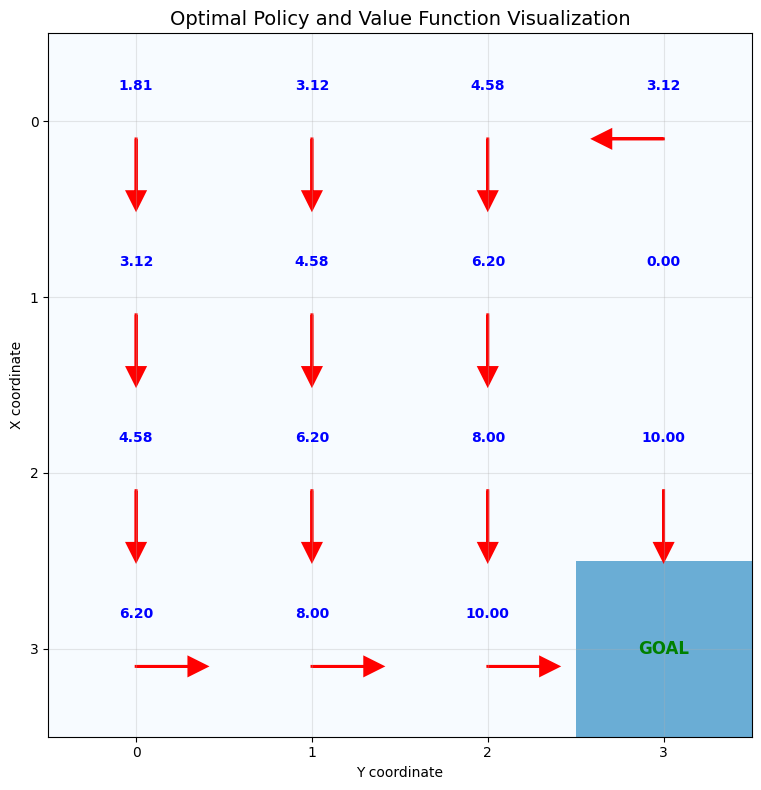

In [78]:
visualize_policy(env, policy, V)

# Increasing the complexity of the environment converting actions to stochastic instead of deterministic


## Questions to answer

### State Space Considerations
#### How to define probability distribution for each action? 
#### Should the probability be uniform across all actions? - Yes
#### How to ensure transitional probabilities sum to 1.0? 

### Algorithm Impact
### Will I need to track additional state information beyong position? 

#### Where in the class or step method should I introduce randomness? 
#### How to ensure that the stochastic transitions work correctly? 



In [ ]:
import numpy as np


class GridWorldStochasticActions: 
    def __init__(self, size=4, obstacle=[(2,3)]): 
        self.size = size
        self.grid = np.zeros((size, size))
        self.start = (0, 0)
        self.goal = (size-1, size-1)
        self.actions = ['U', 'D', 'L', 'R']
        self.state = self.start
        self.obstacle = obstacle

    def reset(self): 
        self.state = self.start
        return self.state
    
    def step(self, action): 
        x,y =  self.state

        # Define trasition probabilities
        # Example: 80% intended direction, 10% left, 10% right

        action_probabilities = {
            'U': [('U', 0.8), ('L', 0.1), ('R', 0.1)],
            'D': [('D', 0.5), ('L', 0.1), ('R', 0.4)],
            'L': [('L', 0.8), ('U', 0.1), ('D', 0.1)],
            'R': [('R', 0.8), ('U', 0.1), ('D', 0.1)],
        }

        # Sample the actual action taken from the probability distribution of intended action
        possible_actions = list(action_probabilities[action].keys())
        probabilities = list(action_probabilities[action].values())
        actual_action = np.random.choice(possible_actions, p=probabilities)

        if actual_action == 'U': 
            x = max(x-1,0)
        elif actual_action == 'D': 
            x = min(x+1, self.size-1)
        elif actual_action == 'L': 
            y = max(y-1,0)
        elif actual_action == 'R': 
            y = min(y+1, self.size-1)
        
        if (x,y) in self.obstacle:
            reward = -1000
            done = False # hitting an obstacle doesn't end the episode
        else:
            self.state = (x,y)
            reward = -1 # default step penalty
    
            if self.state == self.goal: 
                reward = 10
                done = True
            else: 
                done = False
        
        return self.state, reward, done
    
    def get_all_states(self): 
        # I don't want to return states that are obstacles
        all_states = [(x,y) for x in range(self.size) for y in range(self.size)]
        return list(set(all_states) - set(self.obstacle))

    def is_terminal(self, state): 
        return state == self.goal

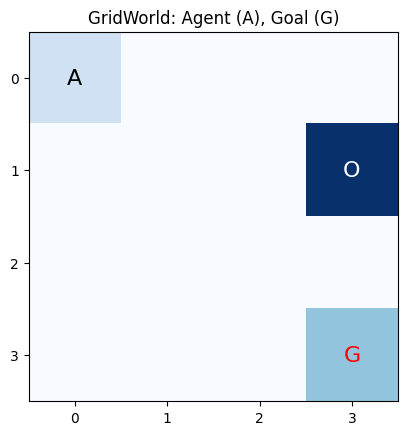

In [6]:
env_stochastic = GridWorldStochasticActions(size=4, obstacle=[(1,3)])
plot_env(env_stochastic)

In [11]:
V, policy = value_iteration(env_stochastic)

AttributeError: 'list' object has no attribute 'keys'